# Setup

In [1]:
%%capture
import scanpy as sc
import scvi
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import scipy

In [2]:
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

# Set up file paths

## demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

## gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Methods

### num genes expressed

In [6]:
def plot_total_genes_normalized_expression(
    adata, genotype_list, threshold=0.02, save_path=None, layer="scVI_normalized", cell_type_key="cell_type",
    genotype_key="genotype", vlim = None, cell_type_list=None, *args, **kwargs,
):
    adata_copy = adata[adata.obs[genotype_key].isin(genotype_list)]
    normalized_expression = pd.DataFrame(
        adata_copy.layers[layer],
        index=adata_copy.obs.index,
        columns=adata_copy.var_names
    )
    normalized_expression = np.log1p(normalized_expression)
    adata_copy.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)

    df = sc.get.obs_df(adata_copy, [f"nGenes_normalized_{threshold}", cell_type_key, genotype_key])
    if cell_type_list is not None:
        df = df[df[cell_type_key].isin(cell_type_list)]
        df[cell_type_key].cat.remove_unused_categories(inplace=True)
        df[cell_type_key].cat.reorder_categories(cell_type_list, inplace=True)
    df[genotype_key].cat.reorder_categories(genotype_list, inplace=True)
    plt.figure(figsize=(len(cell_type_list)*len(genotype_list)*0.3, 3.5))
    sns.violinplot(
        data=df,
        x=cell_type_key,
        y=f"nGenes_normalized_{threshold}",
        hue=genotype_key,
        inner=None,
        *args, **kwargs
    )
    if vlim is not None:
        plt.ylim(vlim[0], vlim[1])
    plt.xticks(rotation=90)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    
def plot_total_genes_raw_expression(
    adata, genotype_list, threshold=0.02, genotype_key="genotype",
    cell_type_key="cell_type", cell_type_list=None, save_path=None, vlim=None,
    layer="counts", *args, **kwargs
):
    raw_expression = {}
    for genotype in genotype_list:
        data = adata[adata.obs[genotype_key] == genotype]
        expression = pd.DataFrame(
            data.layers[layer].todense(),
            index=data.obs.index,
            columns=data.var_names
        )
        expression = expression.div(expression.sum(axis=1), axis=0)*10000
        expression = np.log1p(expression)
        expression["cell_type"] = data.obs[cell_type_key]
        expression = expression.groupby("cell_type").mean()
        raw_expression[genotype] = dict((expression > threshold).sum(axis=1))
    
    plotData = pd.DataFrame(raw_expression).T
    plotData = plotData[cell_type_list]
    plotData = plotData.melt()
    plotData["genotype"] = genotype_list*len(plotData.variable.unique())
    
    plt.figure(figsize=(len(cell_type_list)*len(genotype_list)*0.3, 3.5))
    sns.barplot(
        plotData,
        x="variable",
        y="value",
        hue="genotype",
        *args, **kwargs
    )
    if vlim is not None:
        plt.ylim(vlim[0], vlim[1])
    plt.xticks(rotation=90)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

### num TRAs expressed

In [7]:
def fraction_new_TRAs(
    adata, genotype_list, tra_list, threshold=0.02, save_path=None, layer="scVI_normalized",
    cell_type_key="cell_type", cell_type="Aire+", genotype_key="genotype",
    *args, **kwargs,
):
    adata_copy = adata[(adata.obs[genotype_key].isin(genotype_list)) & (adata.obs[cell_type_key] == cell_type)]
    tra_list = [i for i in tra_list if i in adata_copy.var_names]
    normalized_expression = pd.DataFrame(
        adata_copy.layers[layer],
        index=adata_copy.obs.index,
        columns=adata_copy.var_names
    )
    normalized_expression = np.log1p(normalized_expression)
    normalized_expression["genotype"] = adata_copy.obs[genotype_key]
    normalized_expression = normalized_expression.groupby("genotype").mean()
    normalized_expression = (normalized_expression > threshold).T
    
    normalized_expression_outer = normalized_expression[
        (normalized_expression[genotype_list[0]] == True) &
        (normalized_expression[genotype_list[1]] == False)
    ]
    tras_outer = normalized_expression_outer[normalized_expression_outer.index.isin(tra_list)]
    
    normalized_expression_inner = normalized_expression[
        (normalized_expression[genotype_list[0]] == True) &
        (normalized_expression[genotype_list[2]] == False)
    ]
    tras_inner = normalized_expression_inner[normalized_expression_inner.index.isin(tra_list)]
    
    fig, ax = plt.subplots()

    size = 0.3
    cmap = plt.colormaps["tab20c"]
    outer_colors = cmap([1, 5])
    inner_colors = cmap([3, 7])

    patches = ax.pie(
        [len(tras_outer), len(normalized_expression_outer)-len(tras_outer)],
        radius=1,
        colors=outer_colors,
        wedgeprops=dict(width=size, edgecolor='w'),
        autopct='%1.1f%%',
    )
    ax.legend(loc="best", labels=["TRAs", "non-TRAs"])

    ax.pie(
        [len(tras_inner), len(normalized_expression_inner)-len(tras_inner)],
        radius=1-size,
        colors=inner_colors,
        wedgeprops=dict(width=size, edgecolor='w'),
        autopct='%1.1f%%',
    )

    ax.set(aspect="equal")
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    
def TRA_fraction(adata, cell_type_list, genotype_list, tra_list, layer="scVI_normalized", cell_type_key="cell_type", genotype_key="genotype", save_path=None, threshold=0.02, vlim=None, *args, **kwargs):
    tra_list = [i for i in tra_list if i in adata.var_names]
    normalized_expression = pd.DataFrame(
        adata.layers[layer],
        index=adata.obs.index,
        columns=adata.var_names
    )
    normalized_expression = np.log1p(normalized_expression)
    adata.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)
    # Get num of TSAs expressed above threshold in each cell
    adata.obs[f"nTRAs_normalized_{threshold}"] = (normalized_expression[tra_list] > threshold).sum(axis=1)
    # compute fraction of genes expressed that are TSAs for each cell
    adata.obs["TRA_frac"] = adata.obs[f"nTRAs_normalized_{threshold}"]/adata.obs[f"nGenes_normalized_{threshold}"]
    
    cells = adata[adata.obs[cell_type_key].isin(cell_type_list) & adata.obs[genotype_key].isin(genotype_list)]
    plotData = pd.DataFrame(sc.get.obs_df(cells, ["TRA_frac", genotype_key, cell_type_key]))
    plotData[cell_type_key].cat.reorder_categories(cell_type_list, inplace=True)
    plotData[genotype_key].cat.reorder_categories(genotype_list, inplace=True)

    plt.figure(figsize=(len(cell_type_list)*len(genotype_list)*0.3, 4))
    sns.boxplot(
        plotData,
        x=cell_type_key,
        y="TRA_frac",
        hue=genotype_key,
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    if vlim is not None:
        plt.ylim(vlim[0], vlim[1])
    # plt.axhline(
    #     y = len(tra_list)/adata.shape[1],
    #     color="black",
    #     linestyle="dashed"
    # )
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

### gene list enrichment

In [8]:
def gene_list_enrichment_umap(adata, gene_list, key, genotype_list, genotype_key="genotype", save_path=None):
    vmin=0
    vmax=0
    for i,genotype in enumerate(genotype_list):
        adata_copy = adata[adata.obs[genotype_key] == genotype]
        # Score gene list
        sc.tl.score_genes(adata_copy, gene_list=gene_list, score_name=key)
        # Plot enrichment score on UMAP
        if save_path is not None:
            prefix = save_path.rsplit("/", 1)[1]
            file = f"_{prefix}_{key}.pdf"
            sc.settings.figdir = save_path.rsplit("/", 1)[0]
        else:
            file=None
        if i == 0:
            vmin=np.quantile(adata_copy.obs[key], 0.01)
            vmax=np.quantile(adata_copy.obs[key], 0.99)
        sc.pl.umap(
            adata_copy,
            color=key,
            vmin=vmin,
            vmax=vmax,
            save=file,
        )
    
def gene_list_enrichment_boxplot(
    adata, gene_list, key, cell_type_list, 
    cell_type_key="cell_type", genotype_key="genotype", 
    genotype_list=None, save_path=None, *args, **kwargs
):
    # Score gene list
    sc.tl.score_genes(adata, gene_list=gene_list, score_name=key)
    # Get scores and cell types to DF
    scores = pd.DataFrame({key: adata.obs[key], "cell_type": adata.obs[cell_type_key], "genotype": adata.obs[genotype_key]})
    if cell_type_list is not None:
        # Subset on desires cell types and reorder
        scores = scores[scores.cell_type.isin(cell_type_list)]
        scores.cell_type.cat.remove_unused_categories(inplace=True)
        scores.cell_type.cat.reorder_categories(cell_type_list, inplace=True)
    if genotype_list is not None:
        scores.genotype.cat.reorder_categories(genotype_list, inplace=True)
    # Boxplot of scores across cell types
    fig = plt.figure(figsize=(len(cell_type_list)*len(genotype_list)*0.3,3.5))
    ax = sns.boxplot(
        x=scores.cell_type,
        y=scores[key],
        hue=scores.genotype,
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    ax.grid(False)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()
    return scores

### density of gene expression

In [9]:
def gentoype_gene_expression(
    adata, gene_list, genotype_list, cell_type_key="cell_type",
    cell_type_list=None, genotype_key="genotype", layer="scVI_normalized",
    save_path=None, min_offset=None, *args, **kwargs
):
    gene_list = [i for i in gene_list if i in adata.var_names]
    adata_copy=adata[adata.obs[genotype_key].isin(genotype_list), gene_list]
    tra_expression_data = {}
    for genotype in genotype_list:
        genotype_data = adata_copy[adata_copy.obs[genotype_key] == genotype]
        expression_data = pd.DataFrame(
            genotype_data.layers[layer],
            index=genotype_data.obs.index,
            columns=genotype_data.var_names
        )
        expression_data = np.log1p(expression_data)
        expression_data["cell_type"] = genotype_data.obs[cell_type_key]
        expression_data = expression_data.groupby("cell_type").mean().T
        tra_expression_data[genotype] = expression_data
    for cell_type in cell_type_list:
        plot_data = pd.DataFrame()
        for genotype, tra_expression in tra_expression_data.items():
            plot_data[genotype] = tra_expression[cell_type]
        plot_data = plot_data.melt()
        ax = sns.displot(
            plot_data,
            x="value",
            kind="kde",
            hue="variable",
            *args, **kwargs
        )
        if min_offset is not None:
            plt.xlim(
                min(plot_data.value)-min_offset,
                np.quantile(plot_data.value, 0.99)
            )
        plt.title(cell_type)
        if save_path is not None:
            plt.savefig(save_path, bbox_inches="tight", dpi=300)
        plt.show()
        
def relative_gene_expression(
    adata, gene_lists, cell_type_key="cell_type",
    cell_type_list=None, layer="scVI_normalized",
    save_path=None, xlim=None, *args, **kwargs
):
    lists = {}
    genes = []
    
    for index,gene_list in enumerate(gene_lists):
        gene_list = [i for i in gene_list if i in adata.var_names]
        lists[index] = gene_list
        for i in gene_list:
            genes.append(i)
    genes=list(set(genes))
    adata_copy=adata[:, genes]
                     
    expression_data = pd.DataFrame(
        adata_copy.layers[layer],
        index=adata_copy.obs.index,
        columns=adata_copy.var_names
    )
    expression_data = np.log1p(expression_data)
    expression_data["cell_type"] = adata_copy.obs[cell_type_key]
    expression_data = expression_data.groupby("cell_type").mean().T
    expression_data["gene_list"] = "None"
    
    for key,gene_list in lists.items():
        expression_data.loc[gene_list, "gene_list"] = key
    for cell_type in cell_type_list:
        sns.displot(
            expression_data,
            x=cell_type,
            hue="gene_list",
            kind="kde",
            *args, **kwargs
        )
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    plt.title(cell_type)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

### LFC-LFC plot

In [10]:
def lfc_lfc_plot(
    adata, genotype_list, gene_list_x, gene_list_y, lfc_x, lfc_y,
    layer="scVI_normalized", color_x="tab:blue", color_y="tab:orange",
    color_both="tab:green", save_path=None
):
    gene_list_both = [i for i in gene_list_x if i in gene_list_y]
    gene_list_x = [i for i in gene_list_x if i not in gene_list_both]
    gene_list_y = [i for i in gene_list_y if i not in gene_list_both]
    
    sns.scatterplot(
        x=lfc_x,
        y=lfc_y,
        s=5,
        linewidth=0,
        c="lightgrey"
    )
    sns.scatterplot(
        x=lfc_x[lfc_x.index.isin(gene_list_x)],
        y=lfc_y[lfc_y.index.isin(gene_list_x)],
        s=5,
        linewidth=0,
        c=color_x
    )
    sns.scatterplot(
        x=lfc_x[lfc_x.index.isin(gene_list_y)],
        y=lfc_y[lfc_y.index.isin(gene_list_y)],
        s=5,
        linewidth=0,
        c=color_y
    )
    sns.scatterplot(
        x=lfc_x[lfc_x.index.isin(gene_list_both)],
        y=lfc_y[lfc_y.index.isin(gene_list_both)],
        s=5,
        linewidth=0,
        c=color_both
    )
    plt.axvline(x=-1, linestyle="dashed", color="black")
    plt.axvline(x=1, linestyle="dashed", color="black")
    plt.axhline(y=-1, linestyle="dashed", color="black")
    plt.axhline(y=1, linestyle="dashed", color="black")
    plt.xlabel(f"LFC {genotype_list[0]}/{genotype_list[1]}")
    plt.ylabel(f"LFC {genotype_list[0]}/{genotype_list[2]}")
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

### gene list expression density comparison

In [11]:
def gene_list_expression_comparison(adata, gene_lists, labels, layer="scVI_normalized", *args, **kwargs):
    gene_list_expression = {}
    for i,gene_list in enumerate(gene_lists):
        expression = pd.DataFrame(
            adata[:, gene_list].layers[layer],
            index=adata.obs.index,
            columns=adata[:, gene_list].var_names
        )
        expression = np.log1p(expression)
        gene_list_expression[labels[i]] = expression.mean()
    sns.displot(
        pd.DataFrame(gene_list_expression),
        kind="kde",
        *args, **kwargs
    )

def gene_list_expression_comparison_cell_type(
    adata, gene_lists, cell_type_list, labels, cell_type_key="cell_type",
    layer="scVI_normalized", save_path=None, *args, **kwargs
):
    for cell_type in cell_type_list:
        gene_list_expression = {}
        for i,gene_list in enumerate(gene_lists):
            expression = pd.DataFrame(
                adata[adata.obs[cell_type_key] == cell_type, gene_list].layers[layer],
                index=adata[adata.obs[cell_type_key] == cell_type].obs.index,
                columns=adata[adata.obs[cell_type_key] == cell_type, gene_list].var_names
            )
            expression = np.log1p(expression)
            gene_list_expression[labels[i]] = expression.mean()
        sns.displot(
            pd.DataFrame(gene_list_expression),
            kind="kde",
            *args, **kwargs
        )
        plt.title(cell_type)
        if save_path is not None:
            plt.savefig(save_path, bbox_inches="tight", dip=300)
        plt.show()

## import data

In [12]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
tabulaMurisData = sc.read(f"{processedDataPath}/M_cell/h5ad_files/tabula_muris_expression_filtered_genes.h5ad")
pbmc = sc.read(f"{processedDataPath}/M_cell/h5ad_files/PBMC_all_genes.h5ad")

# Create TRA list

In [13]:
# Get normalized expression
tabulaMurisExpression = pd.DataFrame(
    tabulaMurisData.layers["scVI_normalized"],
    index=tabulaMurisData.obs.index,
    columns=tabulaMurisData.var_names
)
# Log transform expression
tabulaMurisExpression = np.log1p(tabulaMurisExpression)
# Get average expression for each gene across tissues
tabulaMurisExpression["tissue"] = tabulaMurisData.obs.tissue
tabulaMurisExpression = tabulaMurisExpression.groupby("tissue").mean()
# Rescale average expression to a probability distribution across tissues
tabulaMurisExpression = tabulaMurisExpression/tabulaMurisExpression.sum()

In [14]:
# Calculate tissue entropy for each gene
tissueEntropy = pd.DataFrame(
    tabulaMurisExpression.apply(
        scipy.stats.entropy,
        axis=0,
        base=2
    ),
    columns=["entropy"]
)

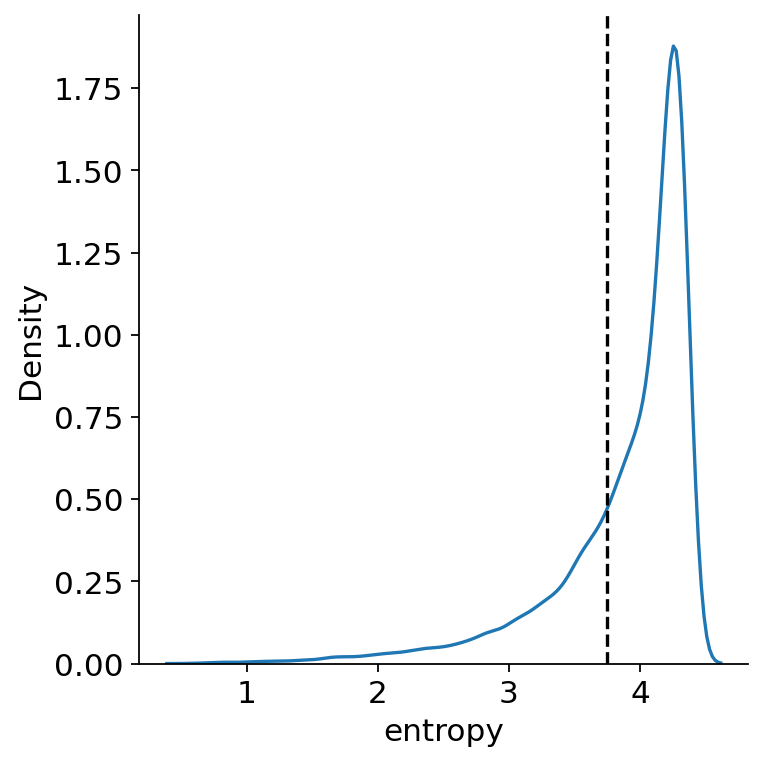

In [15]:
# Plot distribution of entropy scores
ax = sns.displot(tissueEntropy, x="entropy", kind="kde")
plt.axvline(3.75, linestyle="dashed", c="black")
plt.show()

In [16]:
# Select TRAs
TRAs = list(tissueEntropy[tissueEntropy.entropy < 3.75].index)
pd.DataFrame(TRAs).to_csv("../../analysis/TRA_list.csv")

# Total gene expression

## equalize genes in PBMC, thymus datasets

In [17]:
adataShared = adata[:, adata.var_names[adata.var_names.isin(pbmc.var_names)]]
pbmc = pbmc[:, pbmc.var_names[pbmc.var_names.isin(adataShared.var_names)]]
pbmc.obs["genotype"] = "WT"
pbmc.obs.genotype = pbmc.obs.genotype.astype("category")

/tmp/ipykernel_42970/2010857254.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pbmc.obs["genotype"] = "WT"


## normalized expression

/tmp/ipykernel_42970/652712840.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_copy.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)


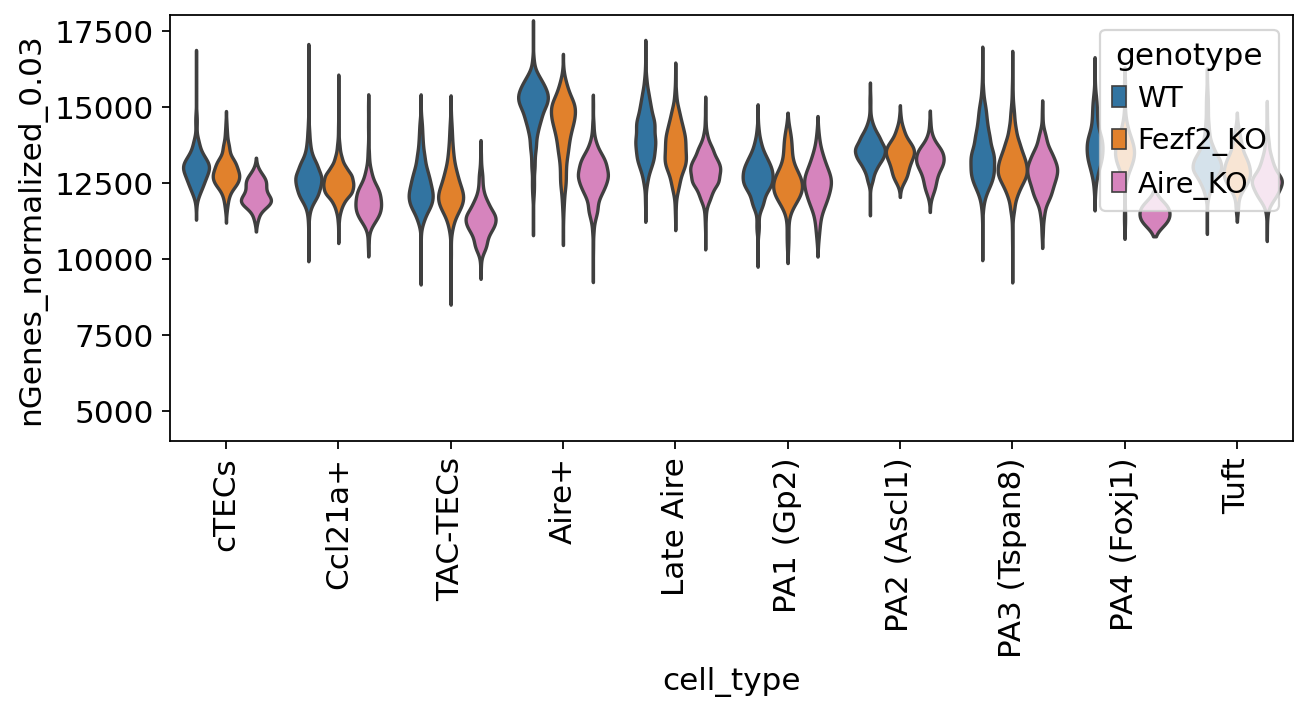

In [18]:
plot_total_genes_normalized_expression(
    adataShared,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["cTECs", "Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    threshold=0.03,
    palette=["tab:blue", "tab:orange", "tab:pink"],
    vlim=[4000, 18000],
)

### Subset of cell type

/tmp/ipykernel_42970/652712840.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_copy.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)


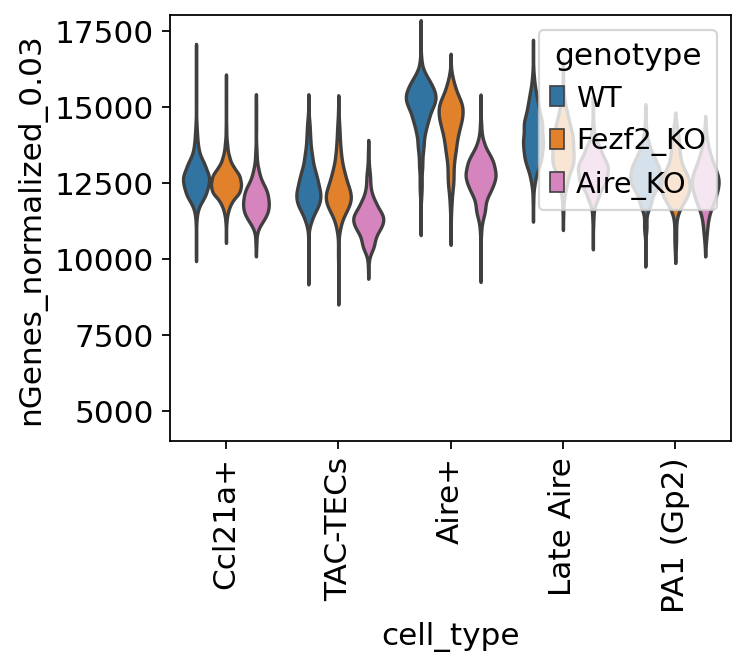

In [19]:
plot_total_genes_normalized_expression(
    adataShared,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)"],
    threshold=0.03,
    palette=["tab:blue", "tab:orange", "tab:pink"],
    vlim=[4000, 18000],
    save_path="../../analysis/Paper figs/2 (AireKO)/2J_num_genes_expressed.pdf"
)

### PBMCs

/tmp/ipykernel_42970/652712840.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_copy.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)


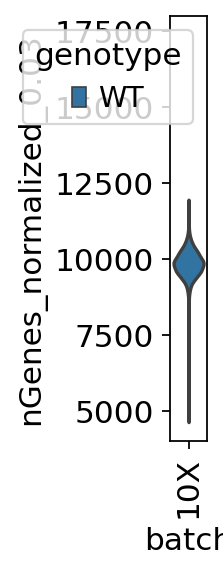

In [20]:
plot_total_genes_normalized_expression(
    pbmc,
    genotype_list=["WT"],
    cell_type_list=pbmc.obs.batch.unique(),
    cell_type_key="batch",
    threshold=0.03,
    palette=["tab:blue"],
    vlim=[4000, 18000],
    save_path="../../analysis/Paper figs/2 (AireKO)/2J_num_genes_expressed_PBMCs.pdf"
)

# TRA expression

## Fraction of all expressed genes that are TRAs

### all cell types

/tmp/ipykernel_42970/2546420405.py:67: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)


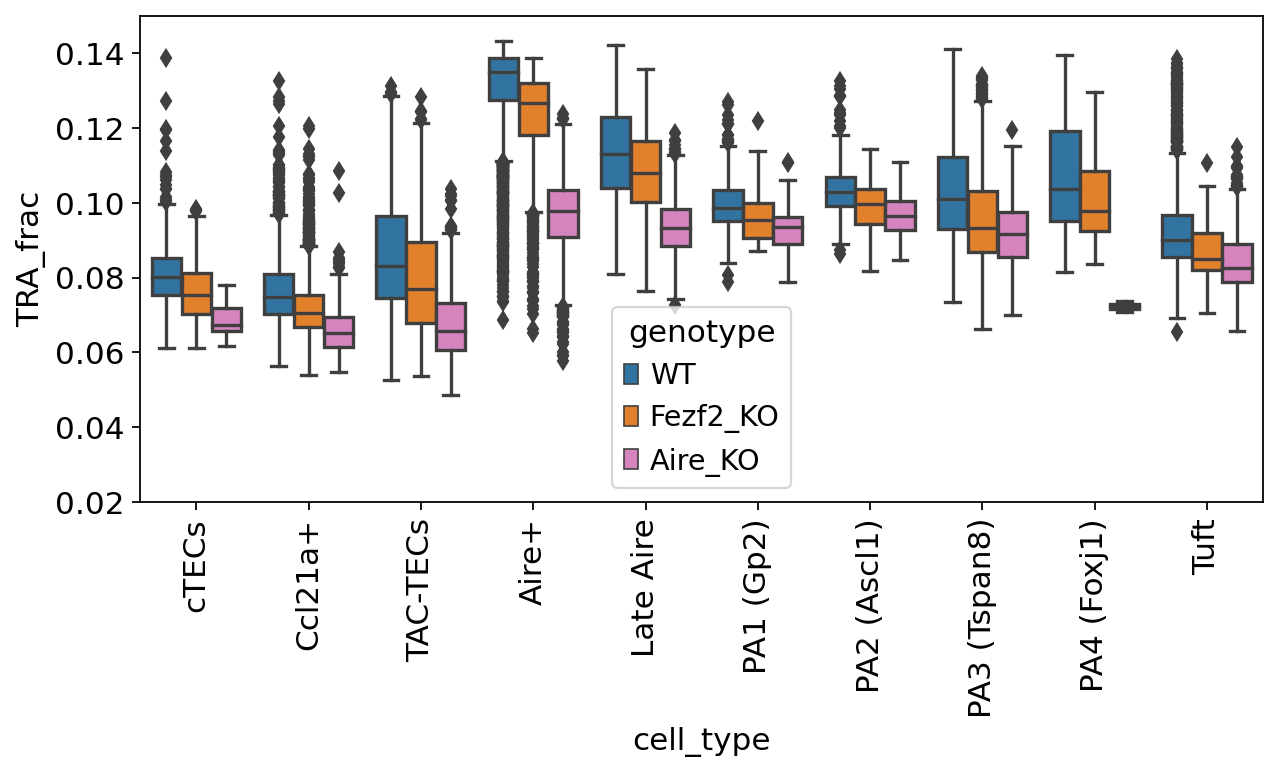

In [21]:
TRA_fraction(
    adataShared,
    cell_type_list=["cTECs", "Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    tra_list=TRAs,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    palette=["tab:blue", "tab:orange", "tab:pink"],
    threshold=0.03,
    save_path=None,
    vlim=[0.02, 0.15],
)

### Subset of cell types

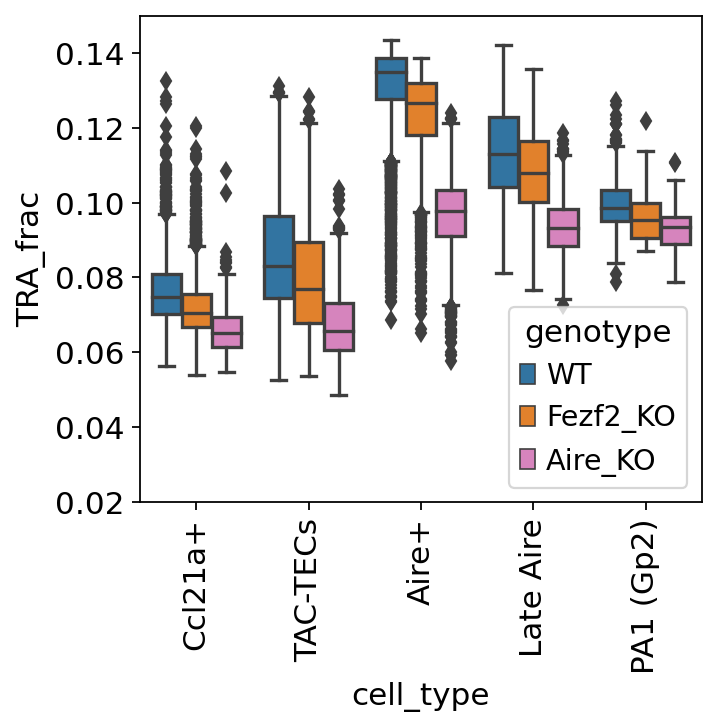

In [22]:
TRA_fraction(
    adataShared,
    cell_type_list=["Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)"],
    tra_list=TRAs,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    palette=["tab:blue", "tab:orange", "tab:pink"],
    threshold=0.03,
    vlim=[0.02, 0.15],
    save_path="../../analysis/Paper figs/2 (AireKO)/2K_frac_TRAs.pdf"
)

### PBMCs

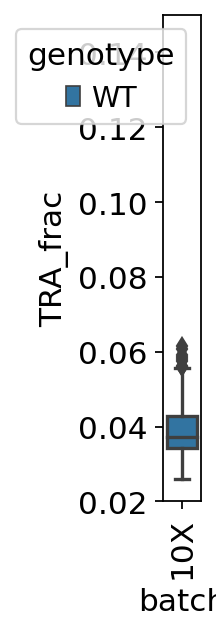

In [23]:
TRA_fraction(
    pbmc,
    cell_type_list=pbmc.obs.batch.unique(),
    cell_type_key="batch",
    tra_list=TRAs,
    genotype_list=["WT"],
    palette=["tab:blue"],
    threshold=0.03,
    vlim=[0.02, 0.15],
    save_path="../../analysis/Paper figs/2 (AireKO)/2K_frac_TRAs_PBMCs.pdf"
)

## Fezf2 vs Aire induced TRA expression

In [24]:
fezf2_induced_TRAs = pd.read_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters_fezf2_induced_TRAs.csv", index_col=0)
aire_induced_TRAs = pd.read_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters_aire_induced_TRAs.csv", index_col=0)

both_TRAs = [i for i in aire_induced_TRAs.index if i in fezf2_induced_TRAs.index]
aire_induced_TRAs = [i for i in aire_induced_TRAs.index if i not in both_TRAs]
fezf2_induced_TRAs = [i for i in fezf2_induced_TRAs.index if i not in both_TRAs]

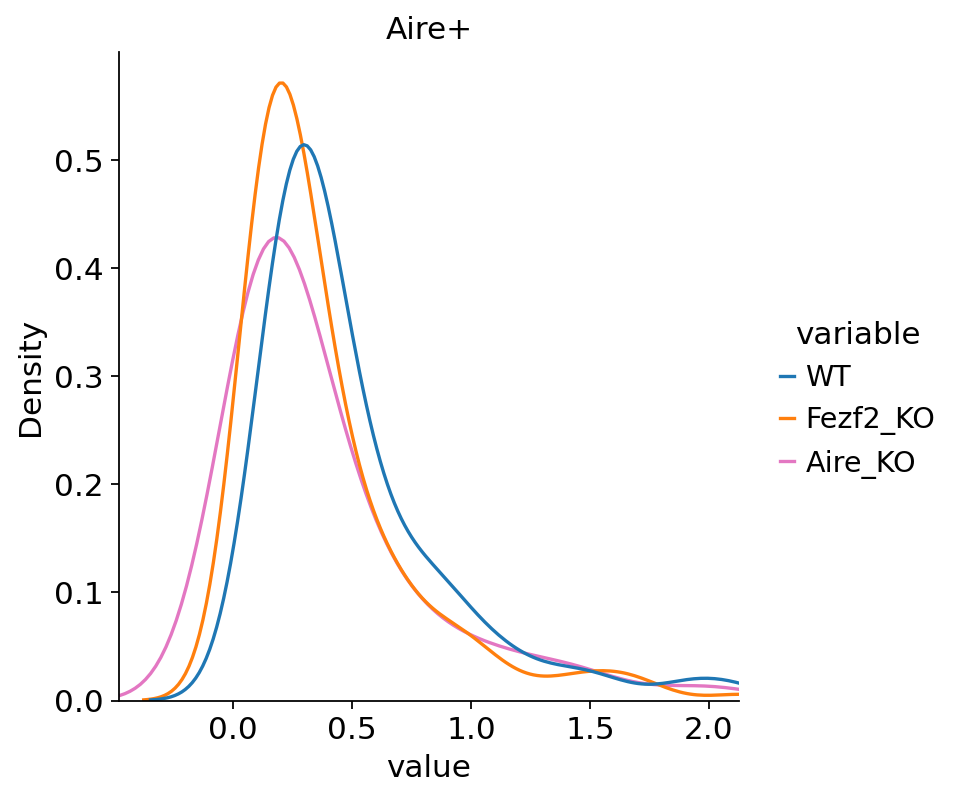

In [26]:
gentoype_gene_expression(
    adata,
    gene_list=fezf2_induced_TRAs,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_key="cell_type",
    cell_type_list=["Aire+"],
    genotype_key="genotype",
    layer="scVI_normalized",
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3E_fezf2_induced_TRA_expression_across_genotypes.pdf",
    min_offset=0.5,
    palette=["tab:blue", "tab:orange", "tab:pink"]
)

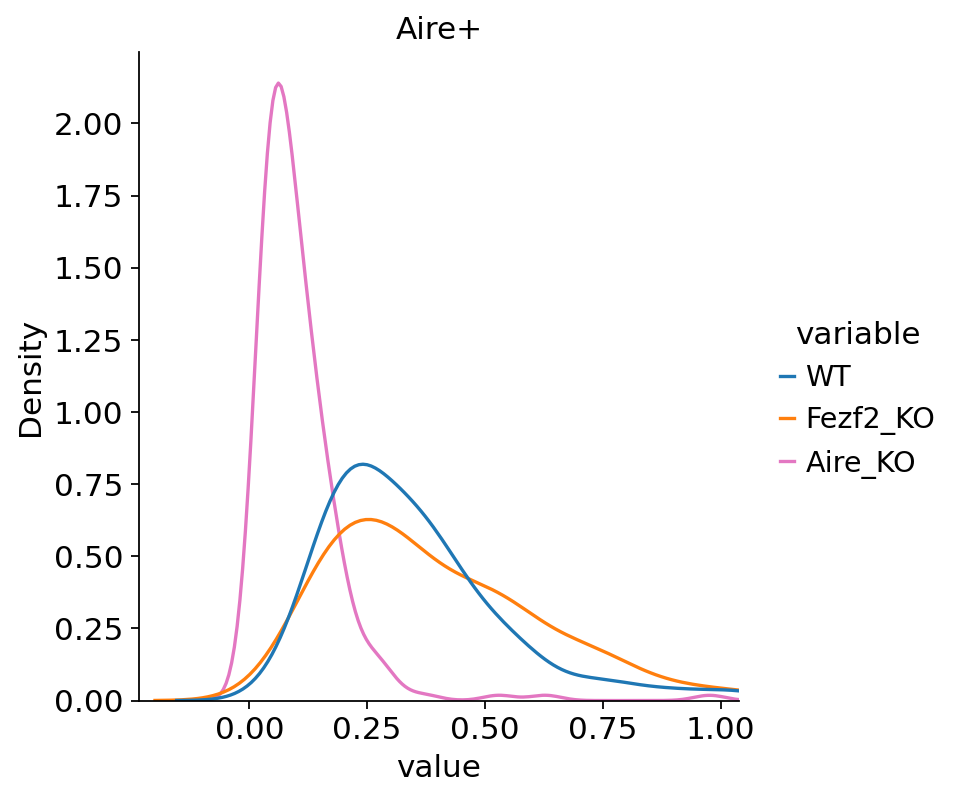

In [27]:
gentoype_gene_expression(
    adata,
    gene_list=aire_induced_TRAs,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["Aire+"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3E_aire_induced_TRA_expression_across_genotypes.pdf",
    min_offset=0.25,
    palette=["tab:blue", "tab:orange", "tab:pink"],
)

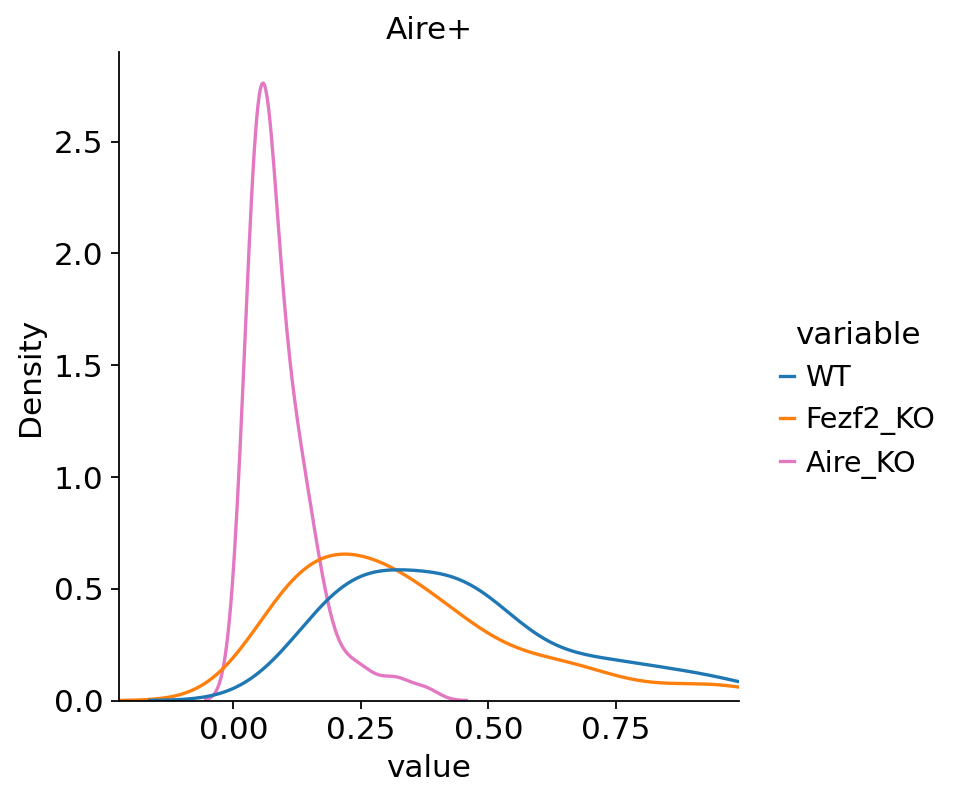

In [28]:
gentoype_gene_expression(
    adata,
    gene_list=both_TRAs,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["Aire+"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3E_both_induced_TRA_expression_across_genotypes.pdf",
    min_offset=0.25,
    palette=["tab:blue", "tab:orange", "tab:pink"],
)

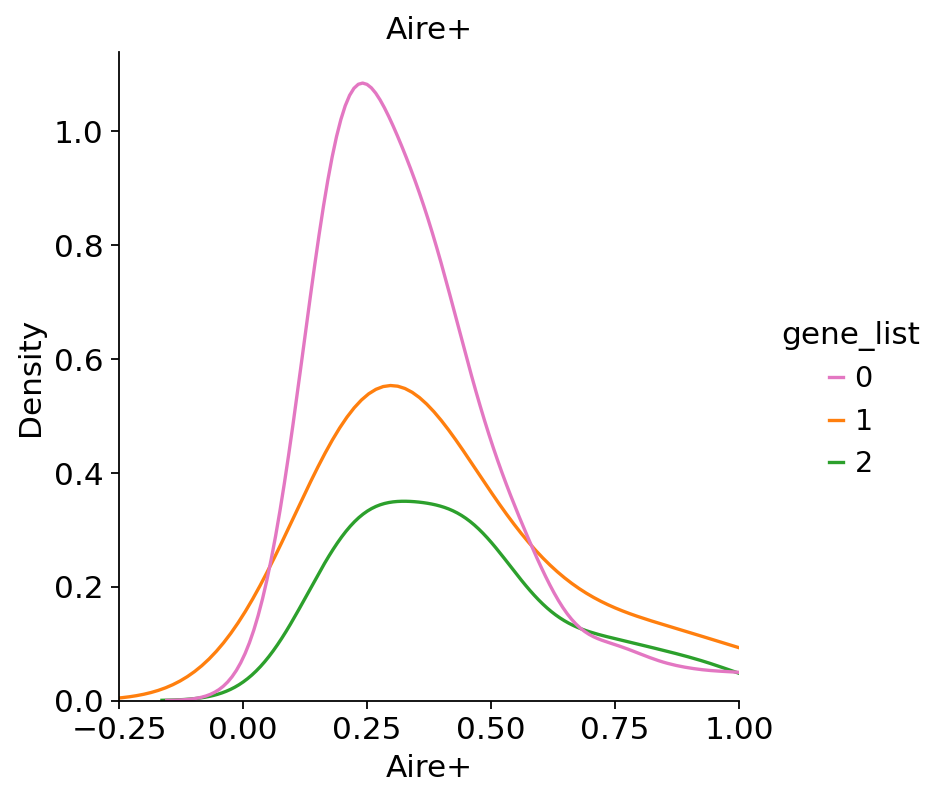

In [30]:
relative_gene_expression(
    adata[adata.obs.genotype == "WT"],
    gene_lists = [aire_induced_TRAs, fezf2_induced_TRAs, both_TRAs],
    cell_type_list=["Aire+"],
    xlim=[-0.25, 1],
    palette=["tab:pink", "tab:orange", "tab:green"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3D_relative_induced_TRA_expression.pdf",
)

# Fezf2 Aire DE gene overlap

## all DE genes

In [31]:
fezf2DE = pd.read_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters.csv", index_col=0)
aireDE = pd.read_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters.csv",index_col=0)
fezf2DE_filtered = pd.read_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters_filtered.csv", index_col=0)
aireDE_filtered = pd.read_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters_filtered.csv",index_col=0)

In [32]:
both = fezf2DE_filtered[fezf2DE_filtered.index.isin(aireDE_filtered.index)]
both["lfc_mean_Aire"] = aireDE_filtered[aireDE_filtered.index.isin(both.index)].lfc_mean

/tmp/ipykernel_42970/3819602205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both["lfc_mean_Aire"] = aireDE_filtered[aireDE_filtered.index.isin(both.index)].lfc_mean


In [33]:
len(both[(both.lfc_mean > 0) & (both.lfc_mean_Aire > 0)])

151

In [34]:
len(fezf2DE_filtered[(~fezf2DE_filtered.index.isin(both.index)) & (fezf2DE_filtered.lfc_mean > 0)])

457

In [35]:
len(both[(both.lfc_mean > 0) & (both.lfc_mean_Aire < 0)])

50

In [36]:
len(both[(both.lfc_mean < 0) & (both.lfc_mean_Aire > 0)])

204

In [37]:
len(fezf2DE_filtered[(~fezf2DE_filtered.index.isin(both.index)) & (fezf2DE_filtered.lfc_mean < 0)])

211

In [38]:
len(both[(both.lfc_mean < 0) & (both.lfc_mean_Aire < 0)])

3

In [39]:
len(aireDE_filtered[(~aireDE_filtered.index.isin(both.index)) & (aireDE_filtered.lfc_mean > 0)])

800

In [40]:
len(aireDE_filtered[(~aireDE_filtered.index.isin(both.index)) & (aireDE_filtered.lfc_mean < 0)])

168

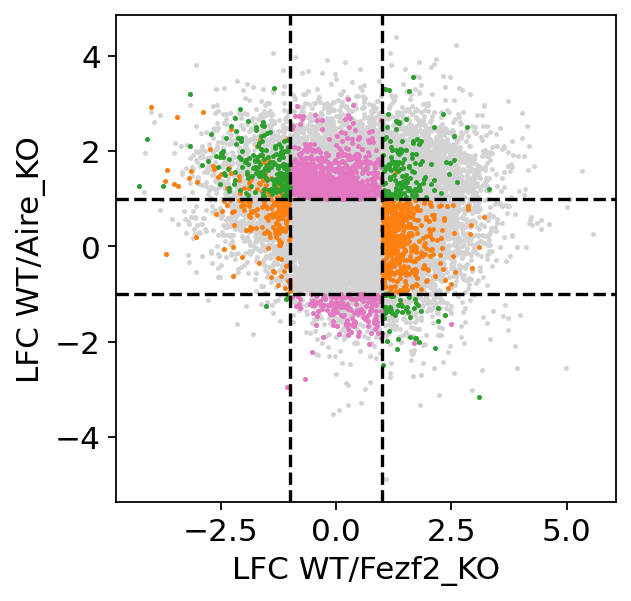

In [42]:
lfc_lfc_plot(
    adata,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    lfc_x=fezf2DE.lfc_mean,
    lfc_y=aireDE.lfc_mean,
    gene_list_x=fezf2DE_filtered.index,
    gene_list_y=aireDE_filtered.index,
    color_x="tab:orange",
    color_y="tab:pink",
    save_path="../../analysis/Paper figs/2 (AireKO)/2L_overlapping_de_genes.pdf"
)

## fezf2 vs Aire induced gene expression

In [43]:
fezf2_induced = [i for i in fezf2DE_filtered[fezf2DE_filtered.lfc_mean > 0].index if i not in aireDE_filtered[aireDE_filtered.lfc_mean > 0].index]
aire_induced = [i for i in aireDE_filtered[aireDE_filtered.lfc_mean > 0].index if i not in fezf2DE_filtered[fezf2DE_filtered.lfc_mean > 0].index]
both = [i for i in aireDE_filtered[aireDE_filtered.lfc_mean > 0].index if i in fezf2DE_filtered[fezf2DE_filtered.lfc_mean > 0].index]

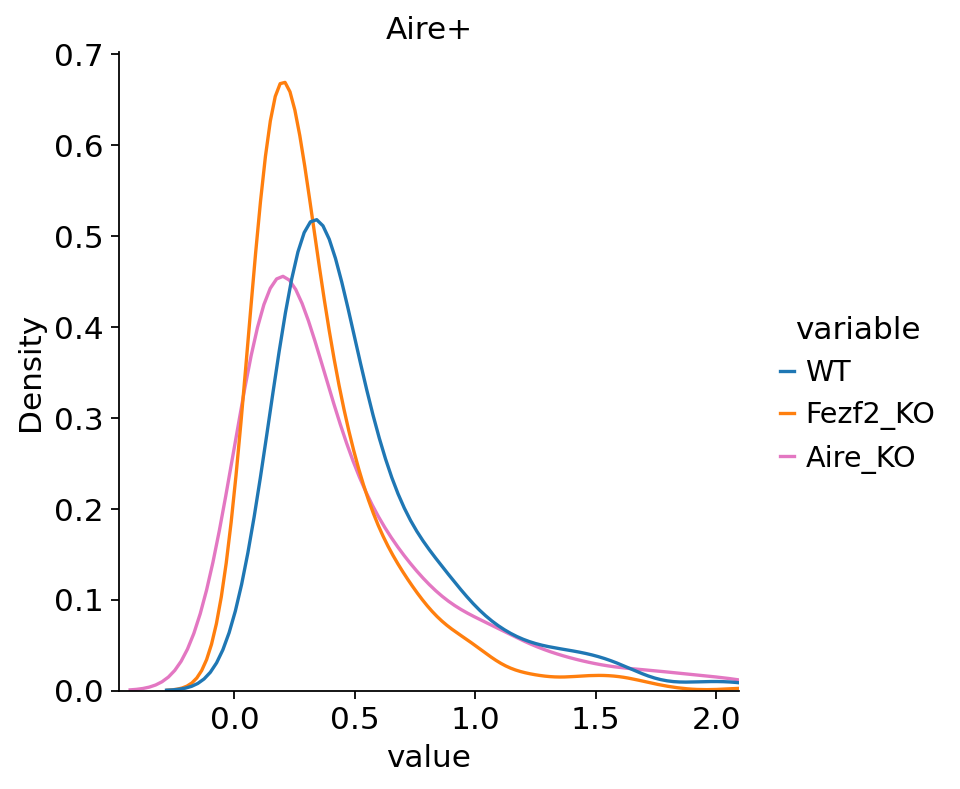

In [45]:
gentoype_gene_expression(
    adata,
    gene_list=fezf2_induced,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_key="cell_type",
    cell_type_list=["Aire+"],
    genotype_key="genotype",
    layer="scVI_normalized",
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3C_fezf2_induced_gene_expression_across_genotypes.pdf",
    min_offset=0.5,
    palette=["tab:blue", "tab:orange", "tab:pink"],
)

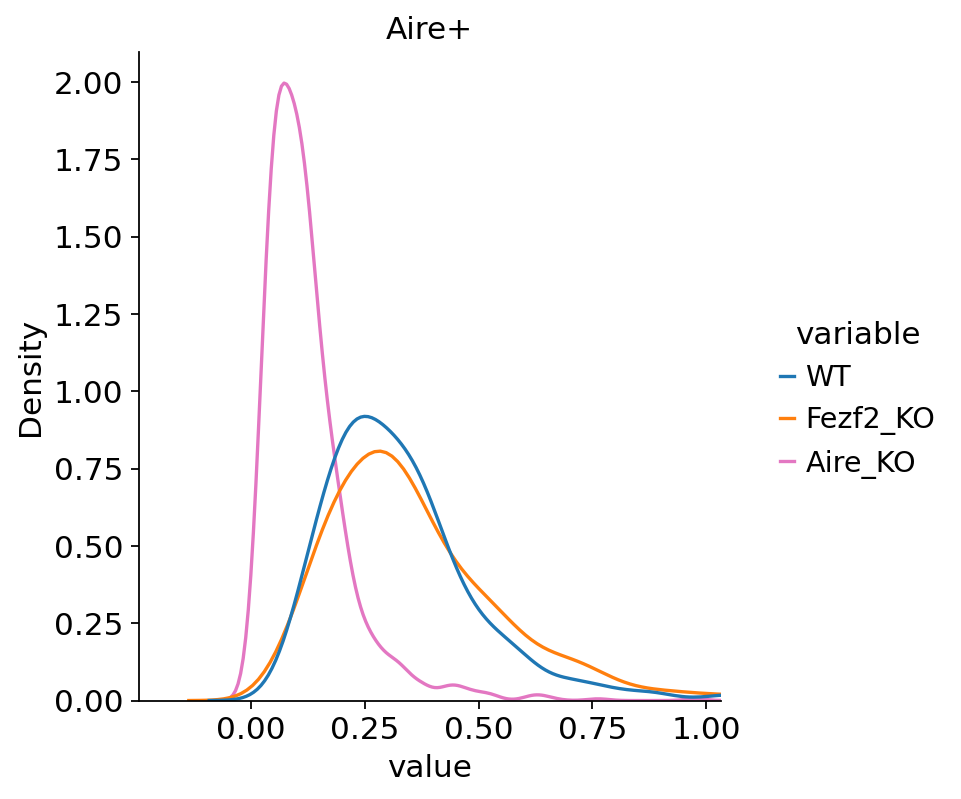

In [49]:
gentoype_gene_expression(
    adata,
    gene_list=aire_induced,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["Aire+"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3C_aire_induced_gene_expression_across_genotypes.pdf",
    min_offset=0.25,
    palette=["tab:blue", "tab:orange", "tab:pink"],
)

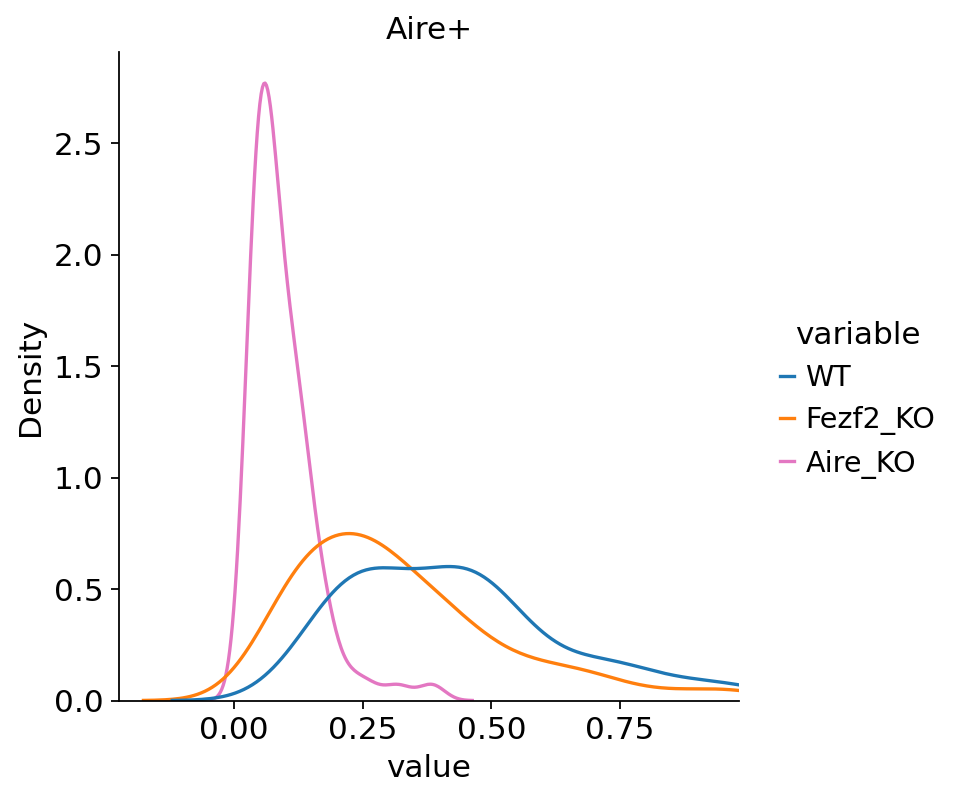

In [47]:
gentoype_gene_expression(
    adata,
    gene_list=both,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["Aire+"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3C_both_induced_gene_expression_across_genotypes.pdf",
    min_offset=0.25,
    palette=["tab:blue", "tab:orange", "tab:pink"],
)

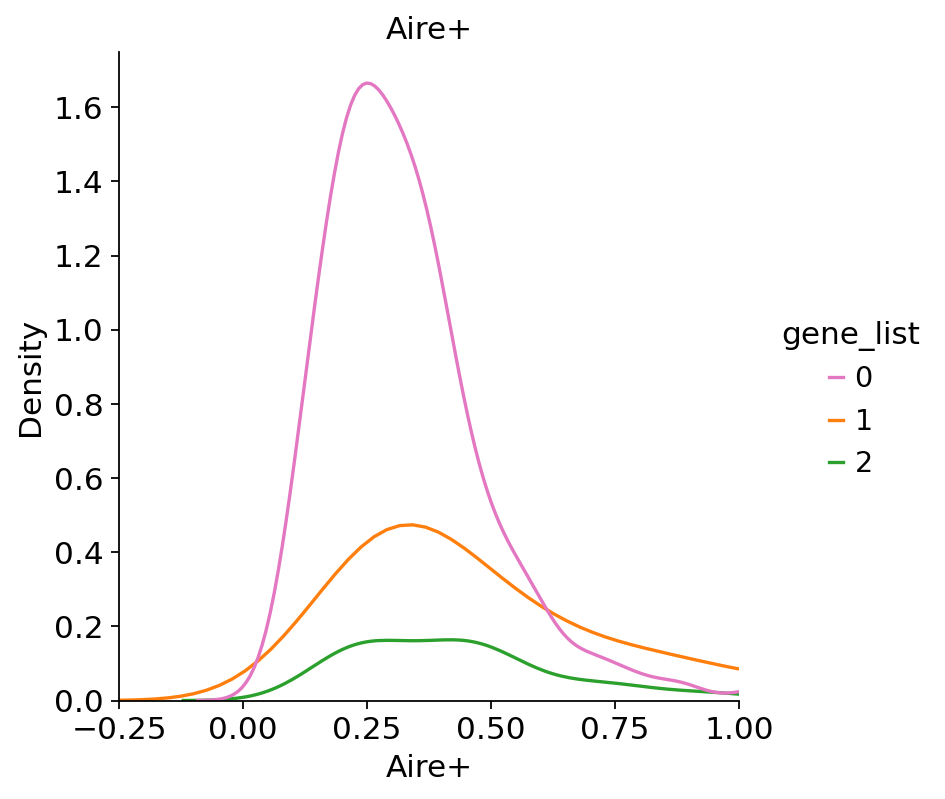

In [50]:
relative_gene_expression(
    adata[adata.obs.genotype == "WT"],
    gene_lists = [aire_induced, fezf2_induced, both],
    cell_type_list=["Aire+"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3B_relative_induced_gene_expression.pdf",
    xlim=[-0.25, 1],
    palette=["tab:pink", "tab:orange", "tab:green"]
)

## TRAs

In [51]:
fezf2DETRAsUp = pd.read_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters_fezf2_repressed_TRAs.csv",index_col=0)
aireDETRAsUp = pd.read_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters_aire_repressed_TRAs.csv",index_col=0)
fezf2DETRAsDown = pd.read_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters_fezf2_induced_TRAs.csv",index_col=0)
aireDETRAsDown = pd.read_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters_aire_induced_TRAs.csv",index_col=0)

fezf2DETRAs = pd.concat([fezf2DETRAsDown, fezf2DETRAsUp])
aireDETRAs = pd.concat([aireDETRAsDown, aireDETRAsUp])

In [52]:
both = fezf2DETRAs[fezf2DETRAs.index.isin(aireDETRAs.index)]
both["lfc_mean_Aire"] = aireDE_filtered[aireDE_filtered.index.isin(both.index)].lfc_mean

/tmp/ipykernel_42970/2350990741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both["lfc_mean_Aire"] = aireDE_filtered[aireDE_filtered.index.isin(both.index)].lfc_mean


In [53]:
fezf2DE = fezf2DE[fezf2DE.index.isin(TRAs)]
aireDE = aireDE[aireDE.index.isin(TRAs)]

In [54]:
len(both[(both.lfc_mean > 0) & (both.lfc_mean_Aire > 0)])

99

In [55]:
len(fezf2DETRAs[(~fezf2DETRAs.index.isin(both.index)) & (fezf2DETRAs.lfc_mean > 0)])

156

In [56]:
len(both[(both.lfc_mean > 0) & (both.lfc_mean_Aire < 0)])

22

In [57]:
len(both[(both.lfc_mean < 0) & (both.lfc_mean_Aire > 0)])

52

In [58]:
len(fezf2DETRAs[(~fezf2DETRAs.index.isin(both.index)) & (fezf2DETRAs.lfc_mean < 0)])

28

In [59]:
len(both[(both.lfc_mean < 0) & (both.lfc_mean_Aire < 0)])

0

In [60]:
len(aireDETRAs[(~aireDETRAs.index.isin(both.index)) & (aireDETRAs.lfc_mean > 0)])

167

In [61]:
len(aireDETRAs[(~aireDETRAs.index.isin(both.index)) & (aireDETRAs.lfc_mean < 0)])

35

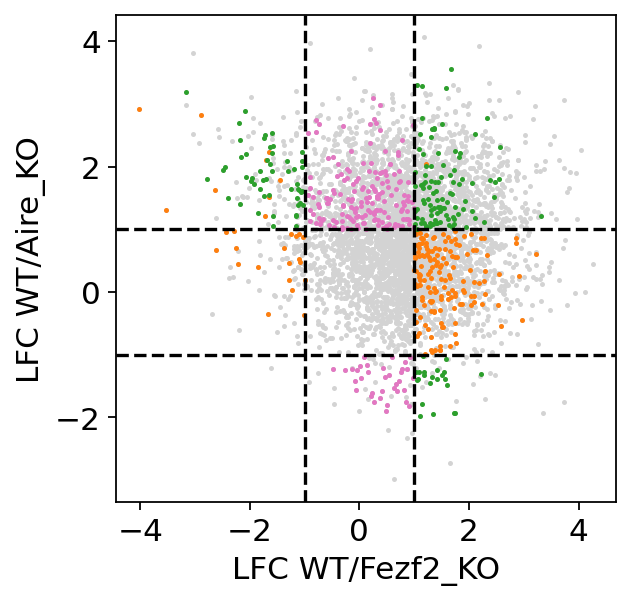

In [62]:
lfc_lfc_plot(
    adata,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    lfc_x=fezf2DE.lfc_mean,
    lfc_y=aireDE.lfc_mean,
    gene_list_x=fezf2DETRAs.index,
    gene_list_y=aireDETRAs.index,
    color_x="tab:orange",
    color_y="tab:pink",
    save_path="../../analysis/Paper figs/2 (AireKO)/2L_overlapping_de_TRAs.pdf"
)